In [19]:
import numpy as np
import time
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.aqua import Operator, run_algorithm

import random
from math import log, pi

In [20]:
# Use Aer's qasm_simulator
backend = Aer.get_backend('qasm_simulator')

In [21]:
# Define layer of quantum circuit.
# For now let's just parameterize the single qubit gates

def rotations(circ, q, n, rotation_params):
    for i in range(n):
        circ.u3(rotation_params[2*i], rotation_params[2*i+1], 0, q[i])

def FC(circ, q, n, FC_params):
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                circ.crz(FC_params[k], q[i], q[j])
                k += 1
                
def layer(circ, q, n, params):
    rotation_params = params[:2*n]
    FC_params = params[2*n : 2*n + n*(n-1)]
    rotations(circ, q, n, rotation_params)
    FC(circ, q, n, FC_params)
    return circ

In [65]:
# function for creating a target distribution

def generate_bars_and_stripes(length, num_samples):
    """ Creates a dataset containing samples showing bars or stripes.
    :param length: Length of the bars/stripes.
    :type length: int
    :param num_samples: Number of samples
    :type num_samples: int
    :return: Samples.
    :rtype: numpy array [num_samples, length*length]
    """
    data = np.zeros((num_samples, length * length))
    for i in range(num_samples):
        values = np.dot(np.random.randint(low=0, high=2,
                                              size=(length, 1)),
                          np.ones((1, length)))
        if np.random.random() > 0.5:
            values = values.T
        data[i, :] = values.reshape(length * length)
    return data


#def get_target():
#    d ={
#    '0000': 1/8,
#    '0110': 1/4,
#    '1001': 1/4,
#    '0101': 1/8,
#    '1010': 1/8,
#    '1111': 1/8}
#    return d

def get_target(length, num_samples):
    
    target = {}
    data = generate_bars_and_stripes(length, num_samples)
    
    for sample in data:
        key = ''.join(map(str, [int(i) for i in sample]))
        
        if key not in target.keys():
            target[key] = 1
        else:
            target[key] += 1
    
    # Normalize target distribution before returning
    for key in target.keys():
        target[key] /= num_samples
    
    return target
    

# define the cost function, here being the KL divergence between the target and learned distributions
def get_cost(target, learned, shots):
    epsilon = 0.01
    cost = 0
    
    for key in learned:
        learned[key] /= shots     # normalize counts from measurements
        
    for key in target:
        if key not in learned:      
            learned[key] = 0         # adds any necessary keys to learned for which we got no counts        
        
        if target[key] != 0:
            cost += target[key]*(log(target[key]) - log(max(epsilon, learned[key])))
    
    return cost

def costFunc(n, target, params, shots):
    learned = run_circuit(n, params, shots)
    cost = get_cost(target, learned, shots)
    
    return cost

def run_circuit(n, params, shots):
    q = QuantumRegister(n)                  #can these be initialized outside the function?
    c = ClassicalRegister(n)
    circ = QuantumCircuit(q, c)
    
    num_params = len(params)
    num_perlayer = 2*n+n*(n-1)
    num_layers = int(num_params/num_perlayer)
    
    for k in range(num_layers):
        circ = layer(circ, q, n, params[num_perlayer*k : num_perlayer*(k+1)])
    
   # n_visible = 4
    for i in range(n):
        circ.measure(q[i], c[i])
    result = execute(circ, backend = backend, shots = shots)
    learned = result.result().get_counts(circ)
    
    return learned

def hist(n, params, shots):
    learned = run_circuit(n, params, shots)
    plot_histogram(learned)

In [38]:
data = generate_bars_and_stripes(length = 2, num_samples = 1000)
len(data)

1000

In [32]:
sample = data[0]
sample_int = ''.join(map(str, [int(i) for i in sample]))
sample_int

'0011'

In [37]:
test = {}
test['0'] = 0
test['1'] = 1
test['1'] += 1

In [26]:
''.join(map(str, data[0]))

'0.00.01.01.0'

In [61]:
# Particle swarm optimizer

class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-0.25,0.25))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self, n, target, costFunc, shots):
        self.err_i=costFunc(n, target, self.position_i, shots)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.75       # constant inertia weight (how much to weigh the previous velocity)
        c1=2        # cognative constant
        c2=2        # social constant
        
        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()
            
            # We need to account for the fact that parameters are angles
            dist_cog = self.pos_best_i[i]-self.position_i[i]
            if dist_cog > pi:
                dist_cog -= 2*pi
            if dist_cog < -pi:
                dist_cog += 2*pi
                
            dist_soc = pos_best_g[i] - self.position_i[i]
            if dist_soc > pi:
                dist_soc -= 2*pi
            if dist_soc < -pi:
                dist_soc += 2*pi

            vel_cognitive=c1*r1*dist_cog
            vel_social=c2*r2*dist_soc
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            #account for particles crossing the 0=2pi line
            if self.position_i[i] > 2*pi:
                self.position_i[i] -= 2*pi
            
            if self.position_i[i] < 0:
                self.position_i[i] += 2*pi
    
                
class PSO():
    def __init__(self,n,shots,target,costFunc,x0,num_particles,maxiter):
        global num_dimensions

        num_dimensions=len(x0)
        self.err_best_g=-1                   # best error for group
        self.pos_best_g=[]                   # best position for group

        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i=0
        while i < maxiter:
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate(n, target, costFunc, shots)

                # determine if current particle is the best (globally)
                if swarm[j].err_i < self.err_best_g or self.err_best_g == -1:
                    self.pos_best_g=list(swarm[j].position_i)
                    self.err_best_g=float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(self.pos_best_g)
                swarm[j].update_position()
            i+=1
            
            if i%2 == 0:
                print("Iteration %d: %f" % (i, self.err_best_g))

        # print final results
        print('FINAL: %f' % self.err_best_g)
        
    
    def best(self):
        return self.pos_best_g
        

if __name__ == "__PSO__":
    main()

In [17]:
n = 3

distribution = np.random.rand(2**n)
distribution /= sum(distribution)

Iteration 2: 1.779523
Iteration 4: 1.374387
Iteration 6: 0.709321
Iteration 8: 0.501210
Iteration 10: 0.456713
Iteration 12: 0.427105
Iteration 14: 0.397274
Iteration 16: 0.397274
Iteration 18: 0.397274
Iteration 20: 0.394971
Iteration 22: 0.394971
Iteration 24: 0.394971
Iteration 26: 0.394971
FINAL: 0.394971


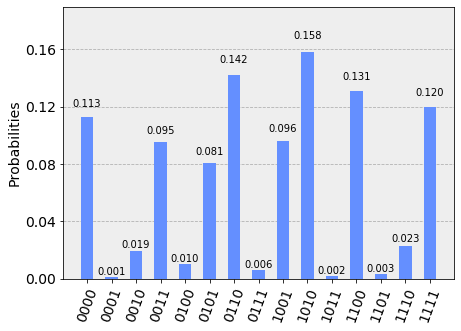

In [75]:
# Run optimization

n = 4
layers = 2
shots = 1000   #shots per run of given circuit; larger will give better statistics from runs

target = get_target(length = 2, num_samples = 1000)

initial = np.random.normal(loc = pi, scale = pi/2, size=int((2*n+n*(n-1))*layers))

best = PSO(n, shots, target, costFunc, initial, num_particles=40, maxiter=26).best()

learned = run_circuit(n, best, shots)
plot_histogram(learned)

In [74]:
target

{'000000000': 0.121,
 '111000111': 0.061,
 '001001001': 0.059,
 '110110110': 0.06,
 '101101101': 0.052,
 '111000000': 0.064,
 '000111000': 0.076,
 '100100100': 0.074,
 '011011011': 0.052,
 '000000111': 0.058,
 '111111111': 0.126,
 '000111111': 0.065,
 '111111000': 0.076,
 '010010010': 0.056}

In [ ]:
params = [4.952183907076087, 5.366143366803098, 6.1802748069211395, 5.423623009334368, 5.277995751340181, 4.9934647678469295]
learned = run_circuit(n, params, shots)
plot_histogram(learned)

In [ ]:
length = len(initial)
layers = int(length/(2*n))
layers

In [ ]:
n=3
k=0
initial

In [ ]:
initial[2*n*k : 2*n*(k+1)]

In [ ]:
n = 3
layers = 3

initial = np.random.normal(loc = pi, scale = pi/2, size=int((2*n+n*(n-1)/2)*layers))
initial

In [ ]:
initial[:6]

In [ ]:
initial[6:7]